Measuring strength of different clusters using TDA

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry as geom
from scipy.ndimage import gaussian_filter

In [2]:
# import numpy as np
# import matplotlib.pyplot as plt

# def plot_betti0_curve(intervals_dim0):
#     """
#     Plots the Betti-0 curve from the birth-death intervals in 'intervals_dim0'.

#     intervals_dim0: np.array of shape (N, 2)
#                     Each row is [birth, death] for a connected component.
#     """
#     # Convert intervals into 'events': (filtration_value, delta)
#     # +1 indicates a birth, -1 indicates a death.
#     events = []
#     for interval in intervals_dim0:
#         birth, death = interval
#         # If birth < death, record both events
#         # (If birth == death, it may be a “0-length” interval; handle as you see fit.)
#         events.append((birth, +1))
#         events.append((death, -1))

#     # Sort events by filtration value
#     events.sort(key=lambda x: x[0])

#     # Build a step function
#     betti_value = 0
#     x_vals = []
#     y_vals = []

#     # Initialize the step at the first event's filtration (optional if everything starts at zero)
#     current_filtration = events[0][0]
#     x_vals.append(current_filtration)
#     y_vals.append(betti_value)

#     for filtration, delta in events:
#         # Move horizontally to the new filtration value at the current Betti number
#         x_vals.append(filtration)
#         y_vals.append(betti_value)
#         # Then jump vertically by delta at the event
#         betti_value += delta
#         # Record the new Betti number
#         x_vals.append(filtration)
#         y_vals.append(betti_value)

#     # Plot the step function for Betti-0
#     plt.step(x_vals, y_vals, where='post')
#     plt.xlabel("Filtration Value")
#     plt.ylabel("Betti-0")
#     plt.title("Betti-0 Curve")
#     plt.show()

# # ------------------------------------------------------------------------------
# # Example usage (assuming you already ran compute_persistence and have intervals_dim0):

# # Suppose you have something like:
# # H0_data_points, TL, AL, TML, AML, intervals_dim0 = compute_persistence(simplices, filtered_df, variable_name)

# # Then you can simply call:
# # plot_betti0_curve(intervals_dim0)
# # ------------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

def get_betti0_step_data(intervals_dim0):
    """
    Given H0 intervals_dim0 = array of [birth, death],
    return x_vals and y_vals for a step function representing Betti-0.
    """
    # Convert intervals to events
    events = []
    for interval in intervals_dim0:
        birth, death = interval
        events.append((birth, +1))   # Birth event
        events.append((death, -1))   # Death event

    # Sort events by filtration value
    events.sort(key=lambda x: x[0])

    # Build the step data
    betti_value = 0
    x_vals = []
    y_vals = []

    # Start from the first event
    if len(events) == 0:
        # No intervals => no connected components to plot
        return [0], [0]  # or return empty lists
    current_filtration = events[0][0]
    x_vals.append(current_filtration)
    y_vals.append(betti_value)

    for filtration, delta in events:
        # Horizontal segment: same Betti value until new event
        x_vals.append(filtration)
        y_vals.append(betti_value)
        # Jump at the event
        betti_value += delta
        # Record new Betti value
        x_vals.append(filtration)
        y_vals.append(betti_value)

    return x_vals, y_vals



In [3]:
def filter_out_zero_and_below(x_vals, y_vals):
    """
    Returns new x_vals, y_vals where x <= 0 are removed.
    """
    x_vals_filtered = []
    y_vals_filtered = []
    for x, y in zip(x_vals, y_vals):
        if x > 0:
            x_vals_filtered.append(x)
            y_vals_filtered.append(y)
    return x_vals_filtered, y_vals_filtered


In [4]:
def generate_grid_dataframe(grid_side_length, autocorrelation="none", n_clusters=2, cluster_radius_val=4, random_seed=42):
    """
    Generates a GeoDataFrame based on a square grid with various spatial patterns.
    
    Parameters:
        grid_side_length (int): The number of squares along one side of the grid.
        autocorrelation (str): Type of spatial autocorrelation. Options:
                               "none" or "random" - No spatial correlation (pure random)
                               "positive" - Spatially smoothed using a Gaussian filter
                               "negative" - Spatially negative correlation (checkerboard pattern)
                               "low_cluster" - Clusters that lower the values relative to the background
                               "high_cluster" - Clusters that raise the values relative to the background
        n_clusters (int): Number of clusters to generate (only used in cluster modes).
        cluster_radius (int, optional): The influence radius for clusters. 
                                        Defaults to grid_side_length // 4 if not provided.
        random_seed (int): Random seed for reproducibility.
        
    Returns:
        GeoDataFrame: A GeoDataFrame containing square geometries and normalized values between 0 and 1.
    """
    np.random.seed(random_seed)  # Set the random seed for reproducibility

    grid_size = (grid_side_length, grid_side_length)
    

    cluster_radius = grid_side_length // cluster_radius_val
    
    if autocorrelation in ["none", "random"]:
        # Pure random values using uniform distribution (0 to 1)
        values = np.random.rand(*grid_size)
        
    elif autocorrelation == "positive":
        # Start with normally distributed values then smooth them
        random_values = np.random.normal(0.5, 0.125, grid_size)
        values = gaussian_filter(random_values, sigma=1.5)
        
    elif autocorrelation == "negative":
        # Create spatially negative correlation using a checkerboard sign flip
        random_values = np.random.normal(0.5, 0.125, grid_size)
        smoothed_values = gaussian_filter(random_values, sigma=1.5)
        checkerboard = np.indices(grid_size).sum(axis=0) % 2  # alternating pattern
        values = smoothed_values * (-1) ** checkerboard
        values += np.random.normal(0, 0.05, grid_size)  # add a bit of noise
        
    elif autocorrelation in ["low_cluster", "high_cluster"]:
        # Start with a random background
        values = np.random.rand(*grid_size)
        # Generate random cluster centers
        cluster_centers = np.random.randint(0, grid_side_length, (n_clusters, 2))
        
        # Apply each cluster's effect based on distance
        for center in cluster_centers:
            y, x = np.ogrid[:grid_side_length, :grid_side_length]
            # Calculate Euclidean distance from the cluster center
            dist = np.sqrt((x - center[1])**2 + (y - center[0])**2)
            # Gaussian decay of cluster effect with distance
            effect = np.exp(-dist**2 / (2 * cluster_radius**2))
            if autocorrelation == "high_cluster":
                values += effect  # add effect to raise values
            else:  # low_cluster: subtract effect to lower values
                values -= effect
        
        # Optionally, add a bit of background noise
        values += np.random.normal(0, 0.05, grid_size)
        
    else:
        raise ValueError("Invalid autocorrelation type. Choose from 'none'/'random', 'positive', 'negative', 'low_cluster', or 'high_cluster'.")

    # # Normalize values to be between 0 and 1
    # min_val = values.min()
    # max_val = values.max()
    # if max_val - min_val > 0:
    #     values = (values - min_val) / (max_val - min_val)
    # else:
    #     values = np.full(grid_size, 0.5)

    # Create a DataFrame for the grid cells
    num_squares = grid_side_length ** 2
    df = pd.DataFrame({'Index': np.arange(num_squares)})
    df['Value'] = values.ravel()

    # Function to calculate square coordinates based on the grid index
    def calculate_square_coordinates(row):
        value = row['Index']
        x = value % grid_side_length
        y = value // grid_side_length
        return geom.Polygon([(x, y), (x+1, y), (x+1, y+1), (x, y+1)])
    
    df['geometry'] = df.apply(calculate_square_coordinates, axis=1)
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    
    return gdf

In [5]:
grid_length = 12

gdf_cluster_str_1 = generate_grid_dataframe(grid_length, autocorrelation="high_cluster", n_clusters=1, cluster_radius_val=2)
gdf_cluster_str_2 = generate_grid_dataframe(grid_length, autocorrelation="high_cluster", n_clusters=1, cluster_radius_val=3)
gdf_cluster_str_3 = generate_grid_dataframe(grid_length, autocorrelation="high_cluster", n_clusters=1, cluster_radius_val=4) 

# print the sum of the values in each grid
print("Sum of the values in each grid")
print(gdf_cluster_str_1['Value'].sum())
print(gdf_cluster_str_2['Value'].sum())
print(gdf_cluster_str_3['Value'].sum())

Sum of the values in each grid
146.91308636360228
116.74961775238611
100.19479513357257


In [6]:
# get the max value of all of three grids
max_value = max(gdf_cluster_str_1['Value'].max(), gdf_cluster_str_2['Value'].max(), gdf_cluster_str_3['Value'].max())
min_value = min(gdf_cluster_str_1['Value'].min(), gdf_cluster_str_2['Value'].min(), gdf_cluster_str_3['Value'].min())

# min max normalization
gdf_cluster_str_1['Value'] = (gdf_cluster_str_1['Value'] - min_value) / (max_value - min_value)
gdf_cluster_str_2['Value'] = (gdf_cluster_str_2['Value'] - min_value) / (max_value - min_value)
gdf_cluster_str_3['Value'] = (gdf_cluster_str_3['Value'] - min_value) / (max_value - min_value)

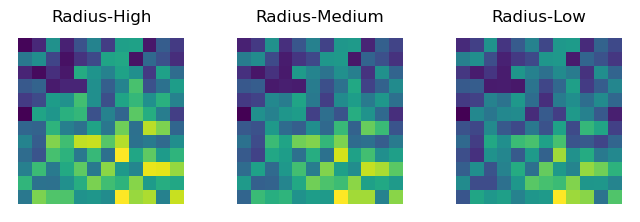

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(8, 5))

# Plot each GeoDataFrame in a separate subplot
gdf_cluster_str_1.plot(column='Value', cmap='viridis', legend=False, ax=axs[0])
gdf_cluster_str_2.plot(column='Value', cmap='viridis', legend=False, ax=axs[1])
gdf_cluster_str_3.plot(column='Value', cmap='viridis', legend=False, ax=axs[2])

# Add titles
axs[0].set_title('Radius-High')
axs[1].set_title('Radius-Medium')
axs[2].set_title('Radius-Low')

# Remove axes
for ax in axs:
    ax.set_axis_off()

# Save the figure
plt.savefig('experiment_1_radius_geo.png', dpi=300, bbox_inches='tight')
plt.show()


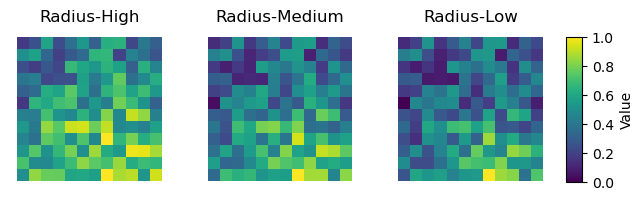

In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Determine global min and max for the "Value" column across all GeoDataFrames
vmin = min(
    gdf_cluster_str_1['Value'].min(),
    gdf_cluster_str_2['Value'].min(),
    gdf_cluster_str_3['Value'].min()
)
vmax = max(
    gdf_cluster_str_1['Value'].max(),
    gdf_cluster_str_2['Value'].max(),
    gdf_cluster_str_3['Value'].max()
)

# Create a normalization object and specify the colormap
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = 'viridis'

# Create the subplots
fig, axs = plt.subplots(1, 3, figsize=(8, 5))

# Plot each GeoDataFrame using the same normalization and colormap
gdf_cluster_str_1.plot(column='Value', cmap=cmap, legend=False, ax=axs[0], norm=norm)
gdf_cluster_str_2.plot(column='Value', cmap=cmap, legend=False, ax=axs[1], norm=norm)
gdf_cluster_str_3.plot(column='Value', cmap=cmap, legend=False, ax=axs[2], norm=norm)

# Add titles
axs[0].set_title('Radius-High')
axs[1].set_title('Radius-Medium')
axs[2].set_title('Radius-Low')

# Remove axes for a cleaner look
for ax in axs:
    ax.set_axis_off()

# Create a ScalarMappable for the colorbar
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Dummy array needed for the colorbar

# Adjust spacing so there's room on the right for the colorbar
fig.subplots_adjust(right=0.8)

# Add a new axis for the colorbar at [left, bottom, width, height] in figure coordinates
# Adjust these values to control the exact position and size of the colorbar
cbar_ax = fig.add_axes([0.82, 0.35, 0.02, 0.29]) 
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Value")

plt.savefig('experiment_1_radius_geo_2.png', dpi=300, bbox_inches='tight')
plt.show()


In [9]:
from utills.adjacency_simplex import AdjacencySimplex 
from utills.calculate_tda_summaries import compute_persistence

Calculating for Radius-High
Calculating for Radius-Medium
Calculating for Radius-Low


/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_34006/1285820045.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df,new_row],ignore_index=True)


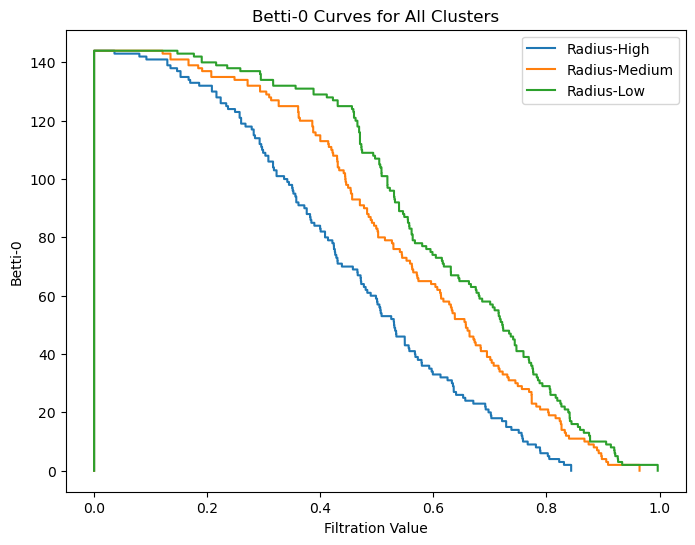

In [10]:
results_df = pd.DataFrame(columns=['GDF','Filter Method','TL','AL','TML','AML','Average'])


# create a dictionary to gdf and name
gdf_dict = {'Radius-High':gdf_cluster_str_1,
            'Radius-Medium':gdf_cluster_str_2,
            'Radius-Low':gdf_cluster_str_3}

# Create one figure for all clusters
plt.figure(figsize=(8, 6))

for name,gdf in gdf_dict.items():
    gdf_temp = gdf.copy()

    average_value = gdf_temp['Value'].mean()
    
    print(f"Calculating for {name}")
    # Initialize the AdjacencySimplex class
    adj_simplex = AdjacencySimplex(gdf_temp, 'Value', threshold = None, filter_method = 'down')

    # Filter the GeoDataFrame
    filtered_df,gdf_id = adj_simplex.filter_sort_gdf()

    # Calculate the adjacent countries
    adj_simplex.calculate_adjacent_countries()

    # Form the simplicial complex
    simplex = adj_simplex.form_simplicial_complex()

    # Compute the persistence
    _,TL, AL, TML, AML,intervals_dim0 = compute_persistence(simplices=simplex,filtered_df=filtered_df,variable_name='Value')

    # Add the results to the results_df
    new_row = pd.DataFrame({'GDF': name,
                                'Filter Method': ['down'],
                                'TL': [TL],
                                'AL': [AL],
                                'TML': [TML],
                                'AML': [AML],
                                'Average': average_value},
                                )
    results_df = pd.concat([results_df,new_row],ignore_index=True)

    # Get Betti-0 step data for this cluster
    x_vals, y_vals = get_betti0_step_data(intervals_dim0)
    
    # Plot on the same figure with a label
    plt.step(x_vals, y_vals, where='post', label=name)


# Add a legend and labels
plt.xlabel("Filtration Value")
plt.ylabel("Betti-0")
plt.title("Betti-0 Curves for All Clusters")
plt.legend()
plt.show()

Calculating for Radius-High
Calculating for Radius-Medium
Calculating for Radius-Low


/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_34006/3518143274.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


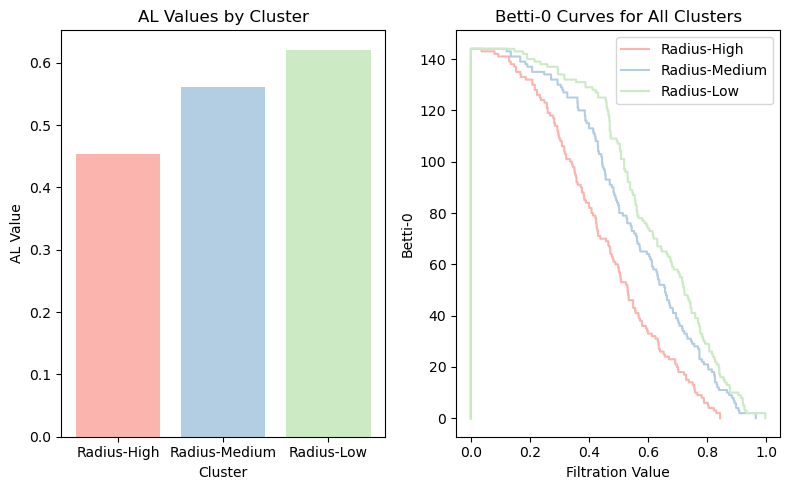

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from cycler import cycler


# Suppose results_df is initially empty with the desired columns
results_df = pd.DataFrame(columns=['GDF','Filter Method','TL','AL','TML','AML','Average'])

# Desired cluster order
desired_order = ["Radius-High", "Radius-Medium", "Radius-Low"]

# Mapping of cluster names to their corresponding GeoDataFrames
# create a dictionary to gdf and name
gdf_dict = {'Radius-High':gdf_cluster_str_1,
            'Radius-Medium':gdf_cluster_str_2,
            'Radius-Low':gdf_cluster_str_3}

# Example: Set the color cycle to use colors from the 'Set1' colormap
plt.rcParams['axes.prop_cycle'] = cycler(color=plt.get_cmap('Pastel1').colors)

# Create a color mapping for each cluster using the default matplotlib color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_dict = {cluster: colors[i % len(colors)] for i, cluster in enumerate(desired_order)}

# Create a figure with two subplots arranged horizontally:
# Left: Vertical bar plot for AL values
# Right: Betti-0 curves
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 5))

# Loop through each cluster to compute persistence and Betti-0 curve data
for name, gdf in gdf_dict.items():
    gdf_temp = gdf.copy()
    average_value = gdf_temp['Value'].mean()
    
    print(f"Calculating for {name}")
    # Initialize and run the persistence pipeline
    adj_simplex = AdjacencySimplex(gdf_temp, 'Value', threshold=None, filter_method='down')
    filtered_df, gdf_id = adj_simplex.filter_sort_gdf()
    adj_simplex.calculate_adjacent_countries()
    simplex = adj_simplex.form_simplicial_complex()
    _, TL, AL, TML, AML, intervals_dim0 = compute_persistence(
        simplices=simplex,
        filtered_df=filtered_df,
        variable_name='Value'
    )
    
    # Append computed metrics to results_df
    new_row = pd.DataFrame({
        'GDF': [name],
        'Filter Method': ['down'],
        'TL': [TL],
        'AL': [AL],
        'TML': [TML],
        'AML': [AML],
        'Average': [average_value]
    })
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    # Get Betti-0 step data and plot on the right subplot using the cluster's assigned color
    x_vals, y_vals = get_betti0_step_data(intervals_dim0)
    ax2.step(x_vals, y_vals, where='post', label=name, color=color_dict[name])

# Reindex results_df so that the rows follow the desired cluster order
results_df_ordered = results_df.set_index('GDF').reindex(desired_order)

# Plot a vertical bar plot for AL values on the left subplot.
ax1.bar(results_df_ordered.index, results_df_ordered['AL'],
         color=[color_dict[cluster] for cluster in desired_order])
ax1.set_title("AL Values by Cluster")
ax1.set_xlabel("Cluster")
ax1.set_ylabel("AL Value")

# Format the Betti-0 subplot
ax2.set_title("Betti-0 Curves for All Clusters")
ax2.set_xlabel("Filtration Value")
ax2.set_ylabel("Betti-0")
ax2.legend()

plt.tight_layout()
# plt.show()
plt.savefig('experiment_1_al_and_betti.png', dpi=300, bbox_inches='tight')



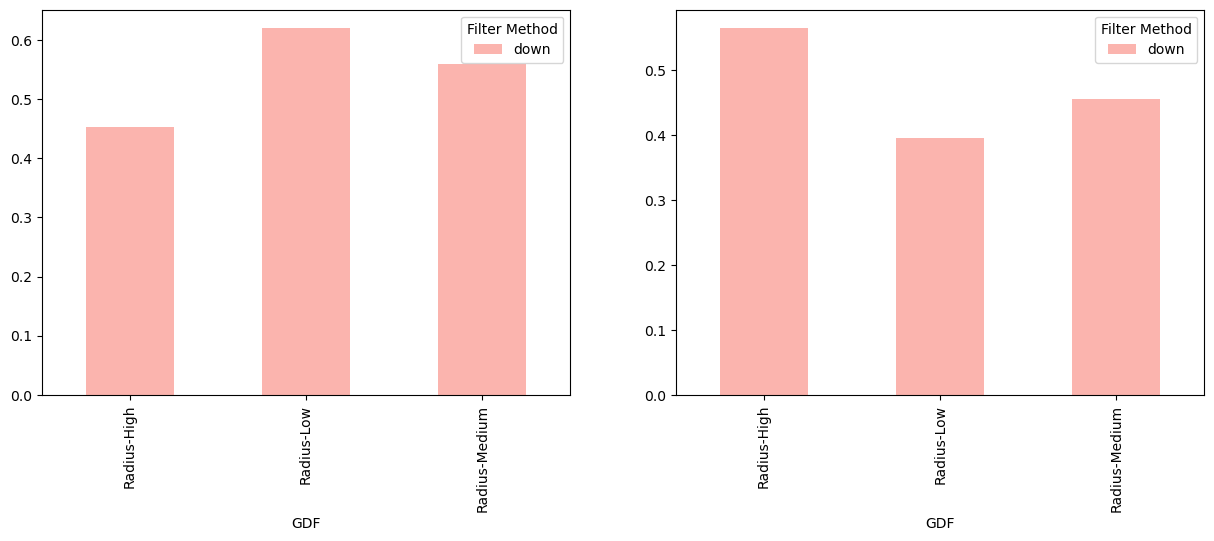

In [12]:
# plot a bar graph of the results for Al values and AML for each gdf
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the bar graph for Al values
results_df.pivot(index='GDF',columns='Filter Method',values='AL').plot(kind='bar',ax=axs[0])

# Plot the bar graph for AML values

results_df.pivot(index='GDF',columns='Filter Method',values='Average').plot(kind='bar',ax=axs[1])

plt.show()

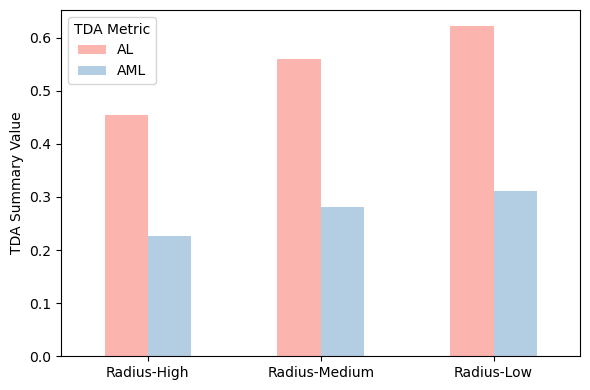

In [13]:

# Assume results_df has columns: ['GDF', 'Filter Method', 'AL', 'AML']
# Example desired order:
desired_order = ["Radius-High", "Radius-Medium", "Radius-Low"]

# 1. Pivot AL and AML separately
pivot_al = results_df.pivot(index='GDF', columns='Filter Method', values='AL')
pivot_aml = results_df.pivot(index='GDF', columns='Filter Method', values='AML')

# 2. Collapse across all Filter Methods by taking an average
pivot_al['AL'] = pivot_al.mean(axis=1)   # average AL across filter methods
pivot_aml['AML'] = pivot_aml.mean(axis=1)  # average AML across filter methods

# 3. Keep only the single "AL" or "AML" column
pivot_al = pivot_al[['AL']]   # discard the individual filter-method columns
pivot_aml = pivot_aml[['AML']]

# 4. Combine AL and AML side by side
combined = pd.concat([pivot_al, pivot_aml], axis=1)

# 5. Reorder the rows by your desired GDF order
combined = combined.reindex(desired_order)

# 6. Plot a grouped bar chart
fig, ax = plt.subplots(figsize=(6, 4))
combined.plot(kind='bar', ax=ax)

# ax.set_title("AL and AML (Averaged Across All Filter Methods), by GDF")
# ax.set_xlabel("GDF")
#remove the x label
plt.xticks(rotation=0)
ax.set_xlabel(None)
ax.set_ylabel("TDA Summary Value")

plt.legend(title="TDA Metric")  # No filter methods anymore, only metrics
plt.tight_layout()

plt.show()
# save plot with DPI 300
# plt.savefig('experiment_1_radius_bar_tda.png', dpi=300, bbox_inches='tight')


In [14]:
results_df

,GDF,Filter Method,TL,AL,TML,AML,Average
0,Radius-High,down,65.359873,0.453888,32.679936,0.226944,0.564231
1,Radius-Medium,down,80.742124,0.560709,40.371062,0.280355,0.454403
2,Radius-Low,down,89.422001,0.620986,44.711000,0.310493,0.394126


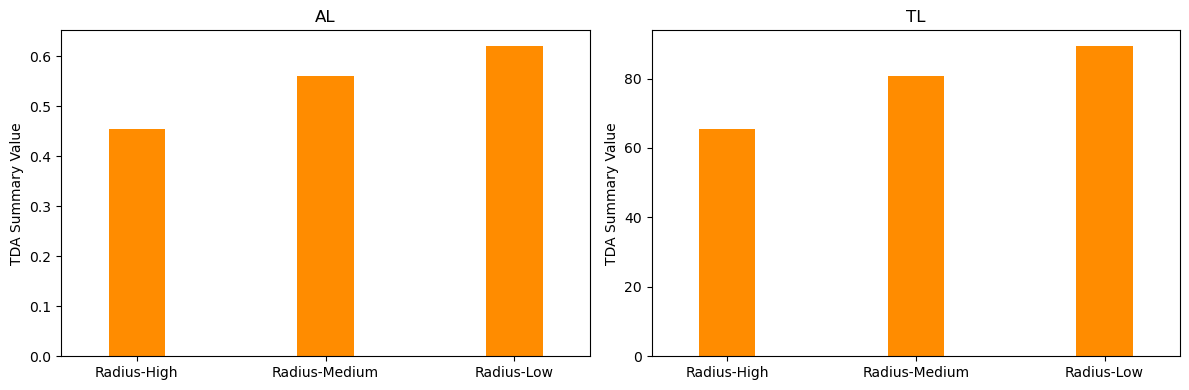

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Suppose results_df already has aggregated values per GDF
# and has columns: ['GDF', 'AL', 'AML']
desired_order = ["Radius-High", "Radius-Medium", "Radius-Low"]

# Reindex the DataFrame to enforce the desired order
combined = results_df.set_index('GDF').reindex(desired_order)

# Create a figure with two subplots arranged horizontally
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

# Plot AL on the left subplot
combined['AL'].plot(kind='bar', ax=ax1, color='darkorange',width=0.3, legend=False)
ax1.set_title("AL")
ax1.set_xlabel(None)
ax1.set_ylabel("TDA Summary Value")
ax1.set_xticklabels(desired_order, rotation=0)

# Plot AML on the right subplot
combined['TL'].plot(kind='bar', ax=ax2, color='darkorange',width=0.3, legend=False)
ax2.set_title("TL")
ax2.set_xlabel(None)
ax2.set_ylabel("TDA Summary Value")
ax2.set_xticklabels(desired_order, rotation=0)

plt.tight_layout()
# plt.savefig('experiment_2_cluster_bar_tda.png', dpi=300, bbox_inches='tight')
plt.show()



/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_34006/1745152663.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(desired_order, rotation=0)
/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_34006/1745152663.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(desired_order, rotation=0)


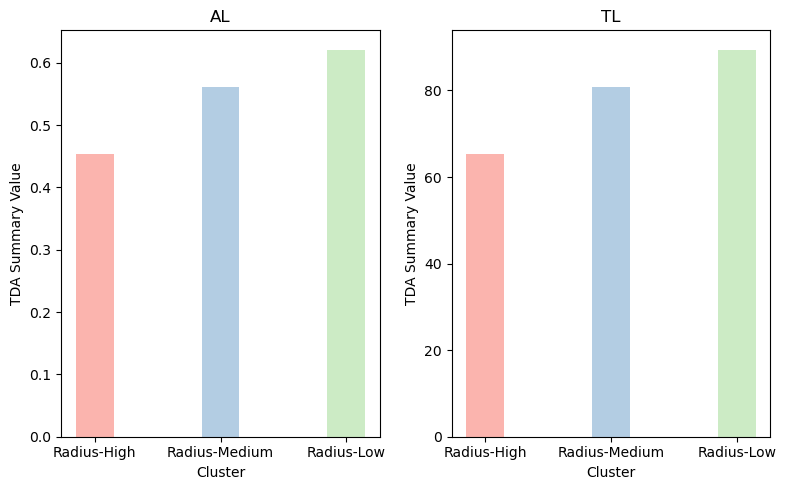

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Suppose results_df already has aggregated values per GDF
# and has columns: ['GDF', 'AL', 'TL']
desired_order = ["Radius-High", "Radius-Medium", "Radius-Low"]

# Reindex the DataFrame to enforce the desired order
combined = results_df.set_index('GDF').reindex(desired_order)

# Create a pastel color mapping using the "Pastel1" colormap
pastel_colors = plt.get_cmap("Pastel1").colors
color_dict = {cluster: pastel_colors[i % len(pastel_colors)] 
              for i, cluster in enumerate(desired_order)}

# Create a figure with two subplots arranged horizontally
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 5))

# Plot AL on the left subplot as a vertical bar plot with pastel colors
ax1.bar(combined.index, combined['AL'],
        color=[color_dict[cluster] for cluster in desired_order],
        width=0.3)
ax1.set_title("AL")
ax1.set_xlabel("Cluster")
ax1.set_ylabel("TDA Summary Value")
ax1.set_xticklabels(desired_order, rotation=0)

# Plot TL on the right subplot as a vertical bar plot with pastel colors
ax2.bar(combined.index, combined['TL'],
        color=[color_dict[cluster] for cluster in desired_order],
        width=0.3)
ax2.set_title("TL")
ax2.set_xlabel("Cluster")
ax2.set_ylabel("TDA Summary Value")
ax2.set_xticklabels(desired_order, rotation=0)

plt.tight_layout()
# plt.show()
plt.savefig('experiment_1_al_and_tl.png', dpi=300, bbox_inches='tight')



Experiment --- 2

In [17]:
grid_length = 18

gdf_cluster_str_1 = generate_grid_dataframe(grid_length, autocorrelation="random")
gdf_cluster_str_2 = generate_grid_dataframe(grid_length, autocorrelation="high_cluster", n_clusters=1, cluster_radius_val=4)
gdf_cluster_str_3 = generate_grid_dataframe(grid_length, autocorrelation="high_cluster", n_clusters=4, cluster_radius_val=4) 
gdf_cluster_str_4 = generate_grid_dataframe(grid_length, autocorrelation="high_cluster", n_clusters=5, cluster_radius_val=4) 


# print the sum of the values in each grid
print("Sum of the values in each grid")
print(gdf_cluster_str_1['Value'].sum())
print(gdf_cluster_str_2['Value'].sum())
print(gdf_cluster_str_3['Value'].sum())
print(gdf_cluster_str_4['Value'].sum())

Sum of the values in each grid
160.159962137489
231.30197914803927
441.5268177510767
511.76341349766466


In [18]:
# get the max value of all of four grids
max_value = max(gdf_cluster_str_1['Value'].max(), gdf_cluster_str_2['Value'].max(), gdf_cluster_str_3['Value'].max(), gdf_cluster_str_4['Value'].max())
min_value = min(gdf_cluster_str_1['Value'].min(), gdf_cluster_str_2['Value'].min(), gdf_cluster_str_3['Value'].min(), gdf_cluster_str_4['Value'].min())

# min max normalization
gdf_cluster_str_1['Value'] = (gdf_cluster_str_1['Value'] - min_value) / (max_value - min_value)
gdf_cluster_str_2['Value'] = (gdf_cluster_str_2['Value'] - min_value) / (max_value - min_value)
gdf_cluster_str_3['Value'] = (gdf_cluster_str_3['Value'] - min_value) / (max_value - min_value)
gdf_cluster_str_4['Value'] = (gdf_cluster_str_4['Value'] - min_value) / (max_value - min_value)


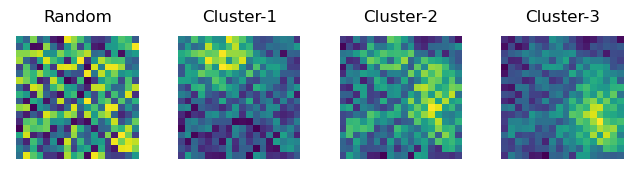

In [19]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(8, 5))

# Plot each GeoDataFrame in a separate subplot
gdf_cluster_str_1.plot(column='Value', cmap='viridis', legend=False, ax=axs[0])
gdf_cluster_str_2.plot(column='Value', cmap='viridis', legend=False, ax=axs[1])
gdf_cluster_str_3.plot(column='Value', cmap='viridis', legend=False, ax=axs[2])
gdf_cluster_str_4.plot(column='Value', cmap='viridis', legend=False, ax=axs[3])


# Add titles
axs[0].set_title('Random')
axs[1].set_title('Cluster-1')
axs[2].set_title('Cluster-2')
axs[3].set_title('Cluster-3')

# Remove axes
for ax in axs:
    ax.set_axis_off()

# Save the figure
plt.savefig('experiment_2_cluster_geo.png', dpi=300, bbox_inches='tight')
plt.show()

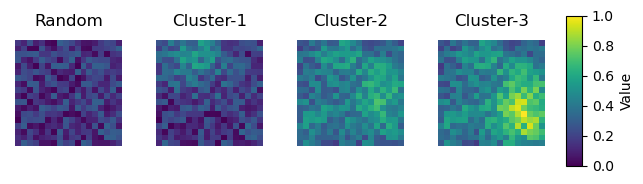

In [20]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Determine the global min and max values for "Value" across all 4 GeoDataFrames
vmin = min(
    gdf_cluster_str_1["Value"].min(),
    gdf_cluster_str_2["Value"].min(),
    gdf_cluster_str_3["Value"].min(),
    gdf_cluster_str_4["Value"].min()
)
vmax = max(
    gdf_cluster_str_1["Value"].max(),
    gdf_cluster_str_2["Value"].max(),
    gdf_cluster_str_3["Value"].max(),
    gdf_cluster_str_4["Value"].max()
)

# Create a normalization object and define the colormap
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = "viridis"

# Create the figure with four subplots
fig, axs = plt.subplots(1, 4, figsize=(8, 5))

# Plot each GeoDataFrame using the same normalization and colormap
gdf_cluster_str_1.plot(column='Value', cmap=cmap, legend=False, ax=axs[0], norm=norm)
gdf_cluster_str_2.plot(column='Value', cmap=cmap, legend=False, ax=axs[1], norm=norm)
gdf_cluster_str_3.plot(column='Value', cmap=cmap, legend=False, ax=axs[2], norm=norm)
gdf_cluster_str_4.plot(column='Value', cmap=cmap, legend=False, ax=axs[3], norm=norm)

# Add titles to each subplot
axs[0].set_title('Random')
axs[1].set_title('Cluster-1')
axs[2].set_title('Cluster-2')
axs[3].set_title('Cluster-3')

# Remove axes for a cleaner look
for ax in axs:
    ax.set_axis_off()

# Create a ScalarMappable for the colorbar
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Dummy array needed for the colorbar

# Adjust spacing so there's room on the right for the colorbar
fig.subplots_adjust(right=0.8)

# Add a new axis for the colorbar at [left, bottom, width, height]
# Tweak these values to get the best position and size
cbar_ax = fig.add_axes([0.82, 0.35, 0.02, 0.3]) 
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Value")

plt.savefig('experiment_2_cluster_geo_2.png', dpi=300, bbox_inches='tight')
plt.show()


Calculating for Random
Calculating for Cluster - 1


/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_34006/4072122554.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df,new_row],ignore_index=True)


Calculating for Cluster - 2
Calculating for Cluster - 3


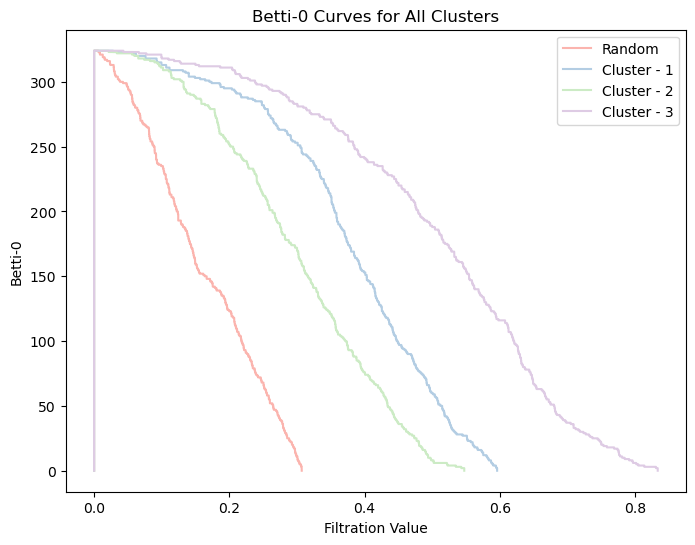

In [21]:
results_df = pd.DataFrame(columns=['GDF','Filter Method','TL','AL','TML','AML','Average'])

# create a dictionary to gdf and name
gdf_dict = {'Random':gdf_cluster_str_1,
            'Cluster - 1':gdf_cluster_str_2,
            'Cluster - 2':gdf_cluster_str_3,
            'Cluster - 3':gdf_cluster_str_4}

# Create one figure for all clusters
plt.figure(figsize=(8, 6))

for name,gdf in gdf_dict.items():
    gdf_temp = gdf.copy()

    average_value = gdf_temp['Value'].mean()
    
    print(f"Calculating for {name}")
    # Initialize the AdjacencySimplex class
    adj_simplex = AdjacencySimplex(gdf_temp, 'Value', threshold = None, filter_method = 'down')

    # Filter the GeoDataFrame
    filtered_df,gdf_id = adj_simplex.filter_sort_gdf()

    # Calculate the adjacent countries
    adj_simplex.calculate_adjacent_countries()

    # Form the simplicial complex
    simplex = adj_simplex.form_simplicial_complex()

    # Compute the persistence
    _,TL, AL, TML, AML,intervals_dim0 = compute_persistence(simplices=simplex,filtered_df=filtered_df,variable_name='Value')

    # Add the results to the results_df
    new_row = pd.DataFrame({'GDF': name,
                                'Filter Method': ['down'],
                                'TL': [TL],
                                'AL': [AL],
                                'TML': [TML],
                                'AML': [AML],
                                'Average': average_value},
                                )
    results_df = pd.concat([results_df,new_row],ignore_index=True)

    # Get Betti-0 step data for this cluster
    x_vals, y_vals = get_betti0_step_data(intervals_dim0)
    
    # Plot on the same figure with a label
    plt.step(x_vals, y_vals, where='post', label=name)


# Add a legend and labels
plt.xlabel("Filtration Value")
plt.ylabel("Betti-0")
plt.title("Betti-0 Curves for All Clusters")
plt.legend()
plt.show()

Calculating for Random
Calculating for Cluster - 1


/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_34006/3823355352.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


Calculating for Cluster - 2
Calculating for Cluster - 3


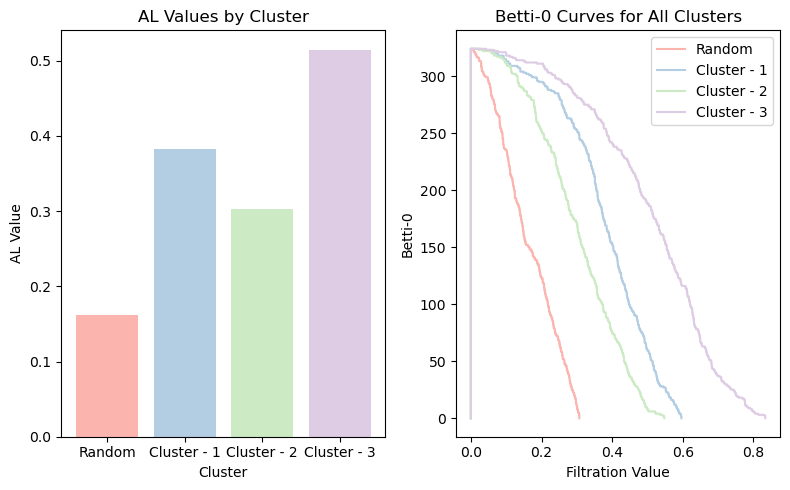

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
from cycler import cycler


# Suppose results_df is initially empty with the desired columns
results_df = pd.DataFrame(columns=['GDF','Filter Method','TL','AL','TML','AML','Average'])

# Desired cluster order
desired_order = ["Random", "Cluster - 1", "Cluster - 2", "Cluster - 3"]

# Mapping of cluster names to their corresponding GeoDataFrames
gdf_dict = {
    'Random': gdf_cluster_str_1,
    'Cluster - 1': gdf_cluster_str_2,
    'Cluster - 2': gdf_cluster_str_3,
    'Cluster - 3': gdf_cluster_str_4
}

# Example: Set the color cycle to use colors from the 'Set1' colormap
plt.rcParams['axes.prop_cycle'] = cycler(color=plt.get_cmap('Pastel1').colors)

# Create a color mapping for each cluster using the default matplotlib color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_dict = {cluster: colors[i % len(colors)] for i, cluster in enumerate(desired_order)}

# Create a figure with two subplots arranged horizontally:
# Left: Vertical bar plot for AL values
# Right: Betti-0 curves
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 5))

# Loop through each cluster to compute persistence and Betti-0 curve data
for name, gdf in gdf_dict.items():
    gdf_temp = gdf.copy()
    average_value = gdf_temp['Value'].mean()
    
    print(f"Calculating for {name}")
    # Initialize and run the persistence pipeline
    adj_simplex = AdjacencySimplex(gdf_temp, 'Value', threshold=None, filter_method='down')
    filtered_df, gdf_id = adj_simplex.filter_sort_gdf()
    adj_simplex.calculate_adjacent_countries()
    simplex = adj_simplex.form_simplicial_complex()
    _, TL, AL, TML, AML, intervals_dim0 = compute_persistence(
        simplices=simplex,
        filtered_df=filtered_df,
        variable_name='Value'
    )
    
    # Append computed metrics to results_df
    new_row = pd.DataFrame({
        'GDF': [name],
        'Filter Method': ['down'],
        'TL': [TL],
        'AL': [AL],
        'TML': [TML],
        'AML': [AML],
        'Average': [average_value]
    })
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    # Get Betti-0 step data and plot on the right subplot using the cluster's assigned color
    x_vals, y_vals = get_betti0_step_data(intervals_dim0)
    ax2.step(x_vals, y_vals, where='post', label=name, color=color_dict[name])

# Reindex results_df so that the rows follow the desired cluster order
results_df_ordered = results_df.set_index('GDF').reindex(desired_order)

# Plot a vertical bar plot for AL values on the left subplot.
ax1.bar(results_df_ordered.index, results_df_ordered['AL'],
         color=[color_dict[cluster] for cluster in desired_order])
ax1.set_title("AL Values by Cluster")
ax1.set_xlabel("Cluster")
ax1.set_ylabel("AL Value")

# Format the Betti-0 subplot
ax2.set_title("Betti-0 Curves for All Clusters")
ax2.set_xlabel("Filtration Value")
ax2.set_ylabel("Betti-0")
ax2.legend()

plt.tight_layout()
# plt.show()
plt.savefig('experiment_2_al_and_betti.png', dpi=300, bbox_inches='tight')

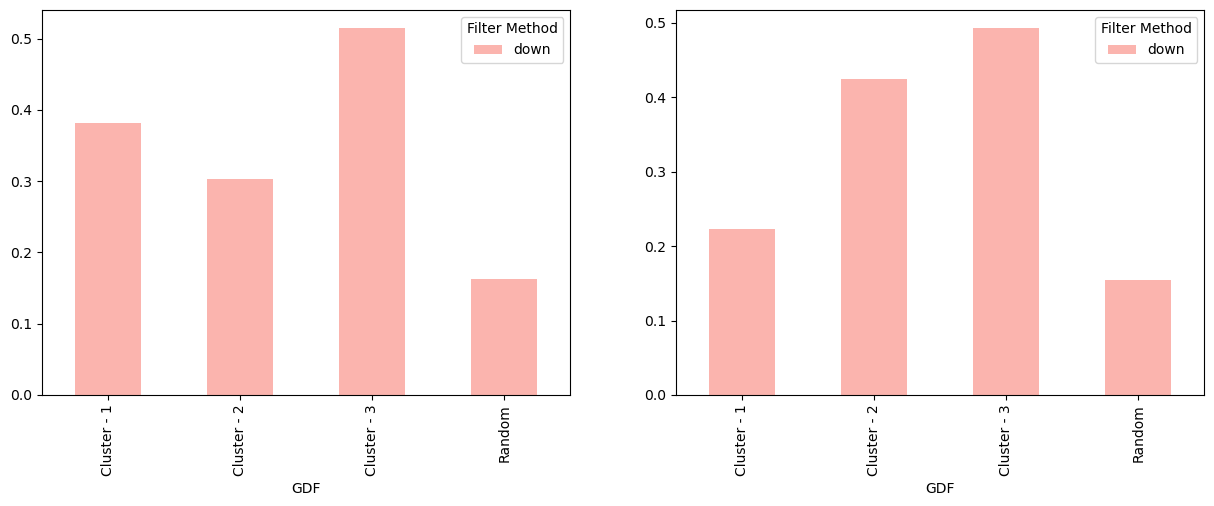

In [23]:
# plot a bar graph of the results for Al values and AML for each gdf
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the bar graph for Al values
results_df.pivot(index='GDF',columns='Filter Method',values='AL').plot(kind='bar',ax=axs[0])

# Plot the bar graph for AML values

results_df.pivot(index='GDF',columns='Filter Method',values='Average').plot(kind='bar',ax=axs[1])

plt.show()

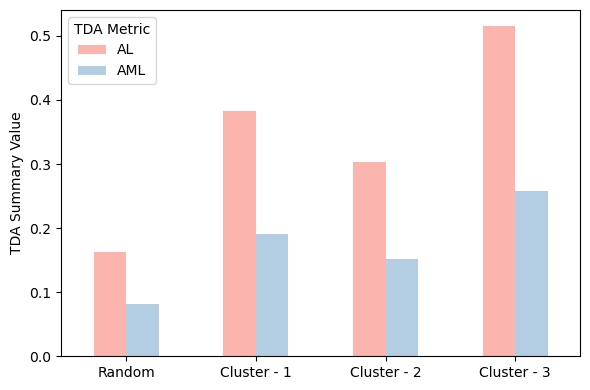

In [24]:

# Assume results_df has columns: ['GDF', 'Filter Method', 'AL', 'AML']
# Example desired order:
desired_order = ["Random", "Cluster - 1", "Cluster - 2", "Cluster - 3"]

# 1. Pivot AL and AML separately
pivot_al = results_df.pivot(index='GDF', columns='Filter Method', values='AL')
pivot_aml = results_df.pivot(index='GDF', columns='Filter Method', values='AML')

# 2. Collapse across all Filter Methods by taking an average
pivot_al['AL'] = pivot_al.mean(axis=1)   # average AL across filter methods
pivot_aml['AML'] = pivot_aml.mean(axis=1)  # average AML across filter methods

# 3. Keep only the single "AL" or "AML" column
pivot_al = pivot_al[['AL']]   # discard the individual filter-method columns
pivot_aml = pivot_aml[['AML']]

# 4. Combine AL and AML side by side
combined = pd.concat([pivot_al, pivot_aml], axis=1)

# 5. Reorder the rows by your desired GDF order
combined = combined.reindex(desired_order)

# 6. Plot a grouped bar chart
fig, ax = plt.subplots(figsize=(6, 4))
combined.plot(kind='bar', ax=ax)

# ax.set_title("AL and AML (Averaged Across All Filter Methods), by GDF")
# ax.set_xlabel("GDF")
#remove the x label
plt.xticks(rotation=0)
ax.set_xlabel(None)
ax.set_ylabel("TDA Summary Value")

plt.legend(title="TDA Metric")  # No filter methods anymore, only metrics
plt.tight_layout()

plt.show()
# save plot with DPI 300
# plt.savefig('experiment_3_cluster_bar_tda.png', dpi=300, bbox_inches='tight')


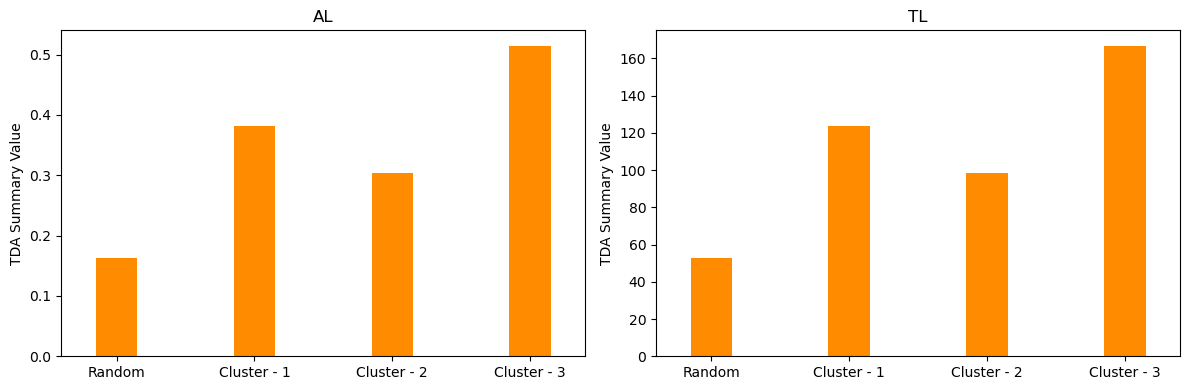

In [25]:
# Suppose results_df already has aggregated values per GDF
# and has columns: ['GDF', 'AL', 'AML']
desired_order = ["Random", "Cluster - 1", "Cluster - 2", "Cluster - 3"]

# Reindex the DataFrame to enforce the desired order
combined = results_df.set_index('GDF').reindex(desired_order)

# Create a figure with two subplots arranged horizontally
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

# Plot AL on the left subplot
combined['AL'].plot(kind='bar', ax=ax1, color='darkorange',width=0.3, legend=False)
ax1.set_title("AL")
ax1.set_xlabel(None)
ax1.set_ylabel("TDA Summary Value")
ax1.set_xticklabels(desired_order, rotation=0)

# Plot AML on the right subplot
combined['TL'].plot(kind='bar', ax=ax2, color='darkorange',width=0.3, legend=False)
ax2.set_title("TL")
ax2.set_xlabel(None)
ax2.set_ylabel("TDA Summary Value")
ax2.set_xticklabels(desired_order, rotation=0)

plt.tight_layout()
# plt.savefig('experiment_2_cluster_bar_tda.png', dpi=300, bbox_inches='tight')
plt.show()

Experiment --- 3

In [26]:
grid_length = 18

gdf_cluster_str_1 = generate_grid_dataframe(grid_length, autocorrelation="random")
gdf_cluster_str_2 = generate_grid_dataframe(grid_length, autocorrelation="high_cluster", n_clusters=2, cluster_radius_val=4)
gdf_cluster_str_3 = generate_grid_dataframe(grid_length, autocorrelation="high_cluster", n_clusters=4, cluster_radius_val=3) 
gdf_cluster_str_4 = generate_grid_dataframe(grid_length, autocorrelation="high_cluster", n_clusters=8, cluster_radius_val=2) 


# print the sum of the values in each grid
print("Sum of the values in each grid")
print(gdf_cluster_str_1['Value'].sum())
print(gdf_cluster_str_2['Value'].sum())
print(gdf_cluster_str_3['Value'].sum())
print(gdf_cluster_str_4['Value'].sum())

Sum of the values in each grid
160.159962137489
294.8265403345451
653.4102276919605
1657.816950867332


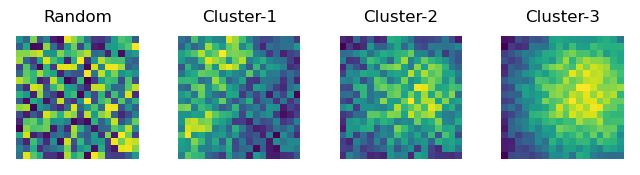

In [27]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(8, 5))

# Plot each GeoDataFrame in a separate subplot
gdf_cluster_str_1.plot(column='Value', cmap='viridis', legend=False, ax=axs[0])
gdf_cluster_str_2.plot(column='Value', cmap='viridis', legend=False, ax=axs[1])
gdf_cluster_str_3.plot(column='Value', cmap='viridis', legend=False, ax=axs[2])
gdf_cluster_str_4.plot(column='Value', cmap='viridis', legend=False, ax=axs[3])


# Add titles
axs[0].set_title('Random')
axs[1].set_title('Cluster-1')
axs[2].set_title('Cluster-2')
axs[3].set_title('Cluster-3')

# Remove axes
for ax in axs:
    ax.set_axis_off()

# Save the figure
plt.savefig('experiment_3_cluster_geo.png', dpi=300, bbox_inches='tight')
plt.show()

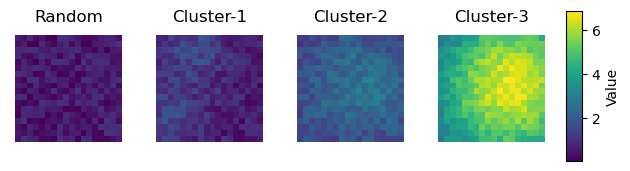

In [28]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Determine the global min and max values for "Value" across all 4 GeoDataFrames
vmin = min(
    gdf_cluster_str_1["Value"].min(),
    gdf_cluster_str_2["Value"].min(),
    gdf_cluster_str_3["Value"].min(),
    gdf_cluster_str_4["Value"].min()
)
vmax = max(
    gdf_cluster_str_1["Value"].max(),
    gdf_cluster_str_2["Value"].max(),
    gdf_cluster_str_3["Value"].max(),
    gdf_cluster_str_4["Value"].max()
)

# Create a normalization object and define the colormap
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = "viridis"

# Create the figure with four subplots
fig, axs = plt.subplots(1, 4, figsize=(8, 5))

# Plot each GeoDataFrame using the same normalization and colormap
gdf_cluster_str_1.plot(column='Value', cmap=cmap, legend=False, ax=axs[0], norm=norm)
gdf_cluster_str_2.plot(column='Value', cmap=cmap, legend=False, ax=axs[1], norm=norm)
gdf_cluster_str_3.plot(column='Value', cmap=cmap, legend=False, ax=axs[2], norm=norm)
gdf_cluster_str_4.plot(column='Value', cmap=cmap, legend=False, ax=axs[3], norm=norm)

# Add titles to each subplot
axs[0].set_title('Random')
axs[1].set_title('Cluster-1')
axs[2].set_title('Cluster-2')
axs[3].set_title('Cluster-3')

# Remove axes for a cleaner look
for ax in axs:
    ax.set_axis_off()

# Create a ScalarMappable for the colorbar
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Dummy array needed for the colorbar

# Adjust spacing so there's room on the right for the colorbar
fig.subplots_adjust(right=0.8)

# Add a new axis for the colorbar at [left, bottom, width, height]
# Tweak these values to get the best position and size
cbar_ax = fig.add_axes([0.82, 0.35, 0.02, 0.3]) 
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Value")

plt.savefig('experiment_3_cluster_geo_2.png', dpi=300, bbox_inches='tight')
plt.show()


In [29]:
# get the max value of all of four grids
max_value = max(gdf_cluster_str_1['Value'].max(), gdf_cluster_str_2['Value'].max(), gdf_cluster_str_3['Value'].max(), gdf_cluster_str_4['Value'].max())
min_value = min(gdf_cluster_str_1['Value'].min(), gdf_cluster_str_2['Value'].min(), gdf_cluster_str_3['Value'].min(), gdf_cluster_str_4['Value'].min())

# min max normalization
gdf_cluster_str_1['Value'] = (gdf_cluster_str_1['Value'] - min_value) / (max_value - min_value)
gdf_cluster_str_2['Value'] = (gdf_cluster_str_2['Value'] - min_value) / (max_value - min_value)
gdf_cluster_str_3['Value'] = (gdf_cluster_str_3['Value'] - min_value) / (max_value - min_value)
gdf_cluster_str_4['Value'] = (gdf_cluster_str_4['Value'] - min_value) / (max_value - min_value)

Calculating for Random
Calculating for Cluster - 1


/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_34006/4072122554.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df,new_row],ignore_index=True)


Calculating for Cluster - 2
Calculating for Cluster - 3


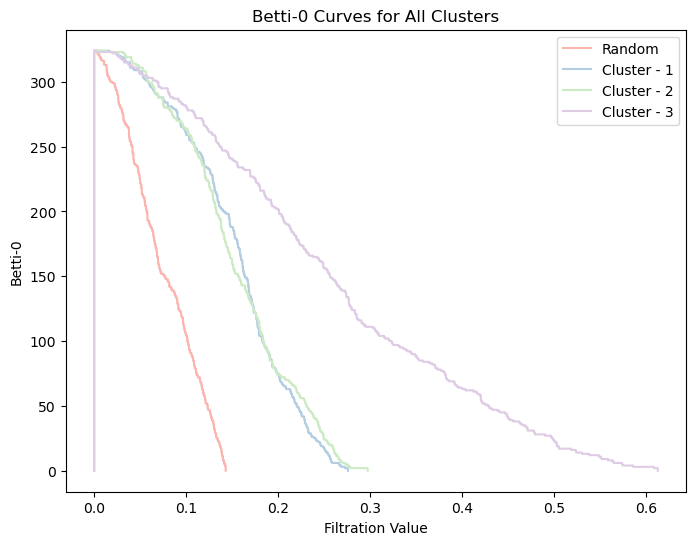

In [30]:
results_df = pd.DataFrame(columns=['GDF','Filter Method','TL','AL','TML','AML','Average'])

# create a dictionary to gdf and name
gdf_dict = {'Random':gdf_cluster_str_1,
            'Cluster - 1':gdf_cluster_str_2,
            'Cluster - 2':gdf_cluster_str_3,
            'Cluster - 3':gdf_cluster_str_4}

# Create one figure for all clusters
plt.figure(figsize=(8, 6))

for name,gdf in gdf_dict.items():
    gdf_temp = gdf.copy()

    average_value = gdf_temp['Value'].mean()
    
    print(f"Calculating for {name}")
    # Initialize the AdjacencySimplex class
    adj_simplex = AdjacencySimplex(gdf_temp, 'Value', threshold = None, filter_method = 'down')

    # Filter the GeoDataFrame
    filtered_df,gdf_id = adj_simplex.filter_sort_gdf()

    # Calculate the adjacent countries
    adj_simplex.calculate_adjacent_countries()

    # Form the simplicial complex
    simplex = adj_simplex.form_simplicial_complex()

    # Compute the persistence
    _,TL, AL, TML, AML,intervals_dim0 = compute_persistence(simplices=simplex,filtered_df=filtered_df,variable_name='Value')

    # Add the results to the results_df
    new_row = pd.DataFrame({'GDF': name,
                                'Filter Method': ['down'],
                                'TL': [TL],
                                'AL': [AL],
                                'TML': [TML],
                                'AML': [AML],
                                'Average': average_value},
                                )
    results_df = pd.concat([results_df,new_row],ignore_index=True)

    # Get Betti-0 step data for this cluster
    x_vals, y_vals = get_betti0_step_data(intervals_dim0)
    
    # Plot on the same figure with a label
    plt.step(x_vals, y_vals, where='post', label=name)


# Add a legend and labels
plt.xlabel("Filtration Value")
plt.ylabel("Betti-0")
plt.title("Betti-0 Curves for All Clusters")
plt.legend()
plt.show()

Calculating for Random
Calculating for Cluster - 1


/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_34006/1447004800.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


Calculating for Cluster - 2
Calculating for Cluster - 3


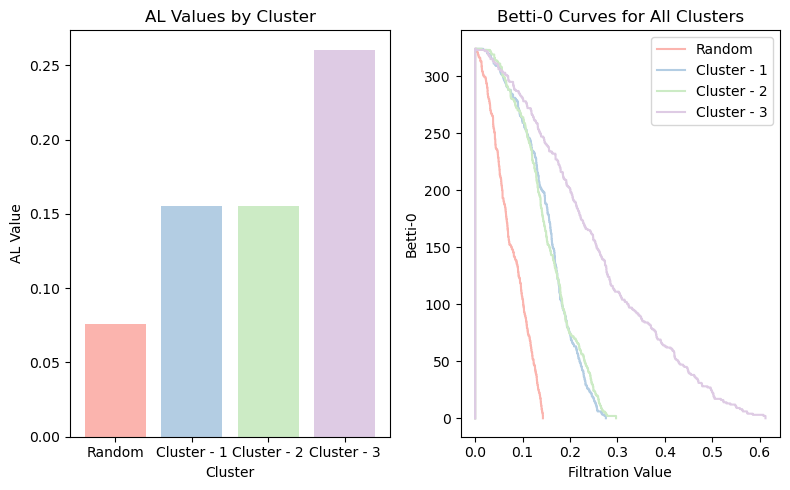

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
from cycler import cycler


# Suppose results_df is initially empty with the desired columns
results_df = pd.DataFrame(columns=['GDF','Filter Method','TL','AL','TML','AML','Average'])

# Desired cluster order
desired_order = ["Random", "Cluster - 1", "Cluster - 2", "Cluster - 3"]

# Mapping of cluster names to their corresponding GeoDataFrames
gdf_dict = {
    'Random': gdf_cluster_str_1,
    'Cluster - 1': gdf_cluster_str_2,
    'Cluster - 2': gdf_cluster_str_3,
    'Cluster - 3': gdf_cluster_str_4
}

# Example: Set the color cycle to use colors from the 'Set1' colormap
plt.rcParams['axes.prop_cycle'] = cycler(color=plt.get_cmap('Pastel1').colors)

# Create a color mapping for each cluster using the default matplotlib color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_dict = {cluster: colors[i % len(colors)] for i, cluster in enumerate(desired_order)}

# Create a figure with two subplots arranged horizontally:
# Left: Vertical bar plot for AL values
# Right: Betti-0 curves
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 5))

# Loop through each cluster to compute persistence and Betti-0 curve data
for name, gdf in gdf_dict.items():
    gdf_temp = gdf.copy()
    average_value = gdf_temp['Value'].mean()
    
    print(f"Calculating for {name}")
    # Initialize and run the persistence pipeline
    adj_simplex = AdjacencySimplex(gdf_temp, 'Value', threshold=None, filter_method='down')
    filtered_df, gdf_id = adj_simplex.filter_sort_gdf()
    adj_simplex.calculate_adjacent_countries()
    simplex = adj_simplex.form_simplicial_complex()
    _, TL, AL, TML, AML, intervals_dim0 = compute_persistence(
        simplices=simplex,
        filtered_df=filtered_df,
        variable_name='Value'
    )
    
    # Append computed metrics to results_df
    new_row = pd.DataFrame({
        'GDF': [name],
        'Filter Method': ['down'],
        'TL': [TL],
        'AL': [AL],
        'TML': [TML],
        'AML': [AML],
        'Average': [average_value]
    })
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    # Get Betti-0 step data and plot on the right subplot using the cluster's assigned color
    x_vals, y_vals = get_betti0_step_data(intervals_dim0)
    ax2.step(x_vals, y_vals, where='post', label=name, color=color_dict[name])

# Reindex results_df so that the rows follow the desired cluster order
results_df_ordered = results_df.set_index('GDF').reindex(desired_order)

# Plot a vertical bar plot for AL values on the left subplot.
ax1.bar(results_df_ordered.index, results_df_ordered['AL'],
         color=[color_dict[cluster] for cluster in desired_order])
ax1.set_title("AL Values by Cluster")
ax1.set_xlabel("Cluster")
ax1.set_ylabel("AL Value")

# Format the Betti-0 subplot
ax2.set_title("Betti-0 Curves for All Clusters")
ax2.set_xlabel("Filtration Value")
ax2.set_ylabel("Betti-0")
ax2.legend()

plt.tight_layout()
# plt.show()
plt.savefig('experiment_3_al_and_betti.png', dpi=300, bbox_inches='tight')


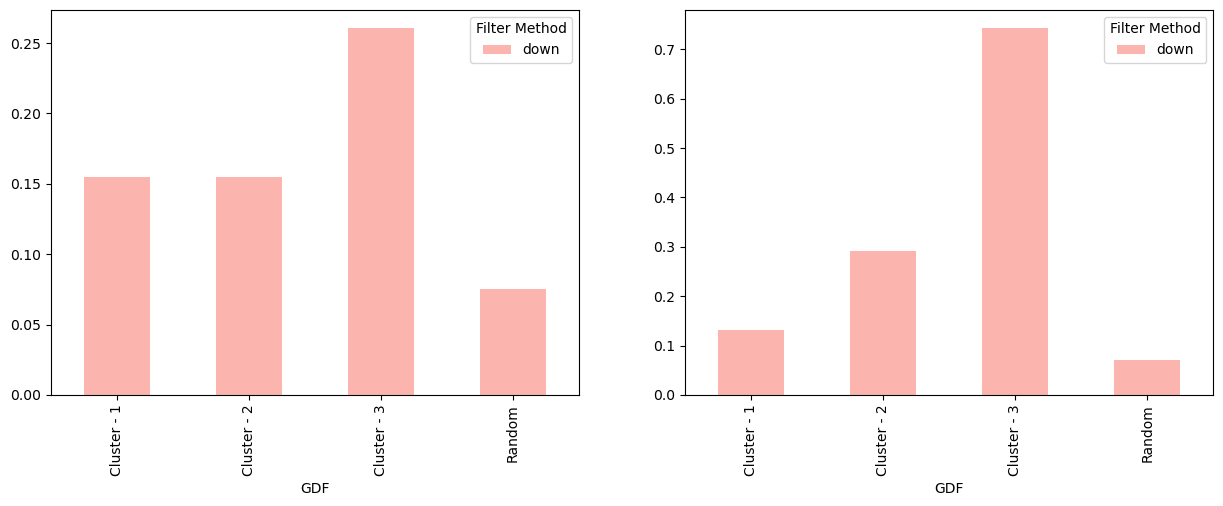

In [32]:
# plot a bar graph of the results for Al values and AML for each gdf
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the bar graph for Al values
results_df.pivot(index='GDF',columns='Filter Method',values='AL').plot(kind='bar',ax=axs[0])

# Plot the bar graph for AML values

results_df.pivot(index='GDF',columns='Filter Method',values='Average').plot(kind='bar',ax=axs[1])

plt.show()

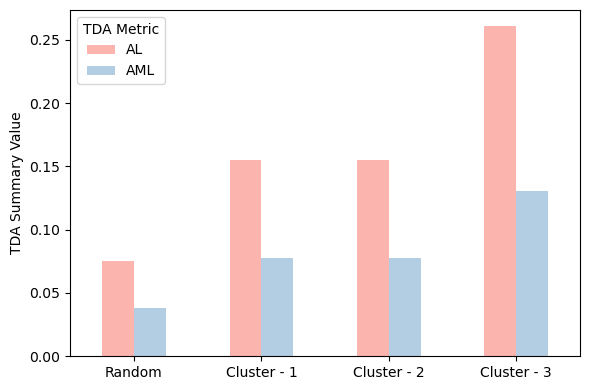

In [33]:

# Assume results_df has columns: ['GDF', 'Filter Method', 'AL', 'AML']
# Example desired order:
desired_order = ["Random", "Cluster - 1", "Cluster - 2", "Cluster - 3"]

# 1. Pivot AL and AML separately
pivot_al = results_df.pivot(index='GDF', columns='Filter Method', values='AL')
pivot_aml = results_df.pivot(index='GDF', columns='Filter Method', values='AML')

# 2. Collapse across all Filter Methods by taking an average
pivot_al['AL'] = pivot_al.mean(axis=1)   # average AL across filter methods
pivot_aml['AML'] = pivot_aml.mean(axis=1)  # average AML across filter methods

# 3. Keep only the single "AL" or "AML" column
pivot_al = pivot_al[['AL']]   # discard the individual filter-method columns
pivot_aml = pivot_aml[['AML']]

# 4. Combine AL and AML side by side
combined = pd.concat([pivot_al, pivot_aml], axis=1)

# 5. Reorder the rows by your desired GDF order
combined = combined.reindex(desired_order)

# 6. Plot a grouped bar chart
fig, ax = plt.subplots(figsize=(6, 4))
combined.plot(kind='bar', ax=ax)

# ax.set_title("AL and AML (Averaged Across All Filter Methods), by GDF")
# ax.set_xlabel("GDF")
#remove the x label
plt.xticks(rotation=0)
ax.set_xlabel(None)
ax.set_ylabel("TDA Summary Value")

plt.legend(title="TDA Metric")  # No filter methods anymore, only metrics
plt.tight_layout()

# plt.show()
# save plot with DPI 300
# plt.savefig('experiment_2_cluster_bar_tda.png', dpi=300, bbox_inches='tight')


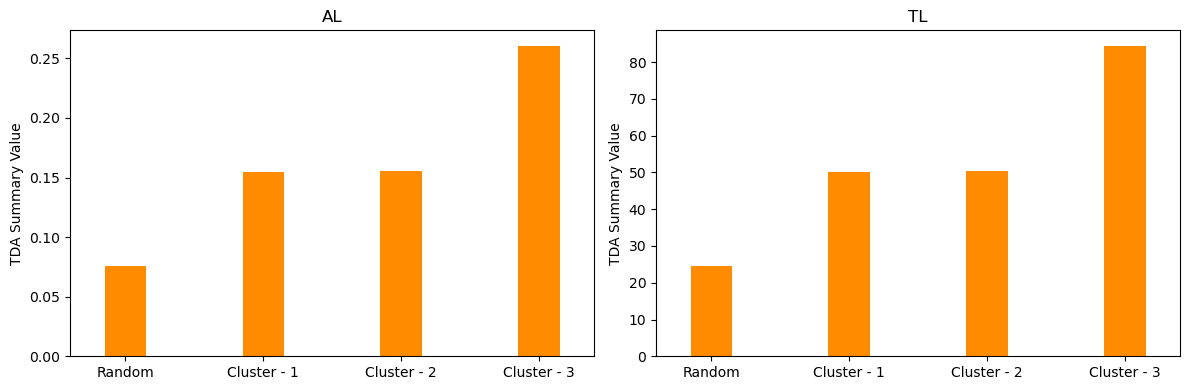

In [34]:
desired_order = ["Random", "Cluster - 1", "Cluster - 2", "Cluster - 3"]

# Reindex the DataFrame to enforce the desired order
combined = results_df.set_index('GDF').reindex(desired_order)

# Create a figure with two subplots arranged horizontally
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

# Plot AL on the left subplot
combined['AL'].plot(kind='bar', ax=ax1, color='darkorange',width=0.3, legend=False)
ax1.set_title("AL")
ax1.set_xlabel(None)
ax1.set_ylabel("TDA Summary Value")
ax1.set_xticklabels(desired_order, rotation=0)

# Plot AML on the right subplot
combined['TL'].plot(kind='bar', ax=ax2, color='darkorange',width=0.3, legend=False)
ax2.set_title("TL")
ax2.set_xlabel(None)
ax2.set_ylabel("TDA Summary Value")
ax2.set_xticklabels(desired_order, rotation=0)

plt.tight_layout()
# plt.savefig('experiment_2_cluster_bar_tda.png', dpi=300, bbox_inches='tight')
plt.show()

Experiment --- 4    

Sum of the values in each grid
60.03605752950003
94.69670882995743
132.2899270374201
177.16068891991


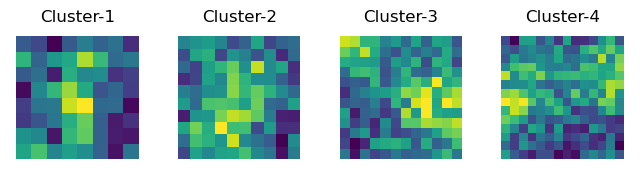

In [35]:
grid_length = 18

gdf_cluster_str_1 = generate_grid_dataframe(8, autocorrelation="high_cluster", n_clusters=6, cluster_radius_val=6, random_seed=42)
gdf_cluster_str_2 = generate_grid_dataframe(10, autocorrelation="high_cluster", n_clusters=2, cluster_radius_val=4, random_seed=43)
gdf_cluster_str_3 = generate_grid_dataframe(12, autocorrelation="high_cluster", n_clusters=2, cluster_radius_val=4, random_seed=44) 
gdf_cluster_str_4 = generate_grid_dataframe(14, autocorrelation="high_cluster", n_clusters=2, cluster_radius_val=4, random_seed=45) 


# print the sum of the values in each grid
print("Sum of the values in each grid")
print(gdf_cluster_str_1['Value'].sum())
print(gdf_cluster_str_2['Value'].sum())
print(gdf_cluster_str_3['Value'].sum())
print(gdf_cluster_str_4['Value'].sum())

fig, axs = plt.subplots(1, 4, figsize=(8, 5))

# Plot each GeoDataFrame in a separate subplot
gdf_cluster_str_1.plot(column='Value', cmap='viridis', legend=False, ax=axs[0])
gdf_cluster_str_2.plot(column='Value', cmap='viridis', legend=False, ax=axs[1])
gdf_cluster_str_3.plot(column='Value', cmap='viridis', legend=False, ax=axs[2])
gdf_cluster_str_4.plot(column='Value', cmap='viridis', legend=False, ax=axs[3])


# Add titles
axs[0].set_title('Cluster-1')
axs[1].set_title('Cluster-2')
axs[2].set_title('Cluster-3')
axs[3].set_title('Cluster-4')

# Remove axes
for ax in axs:
    ax.set_axis_off()

# Save the figure
plt.savefig('experiment_4_cluster_geo.png', dpi=300, bbox_inches='tight')
plt.show()

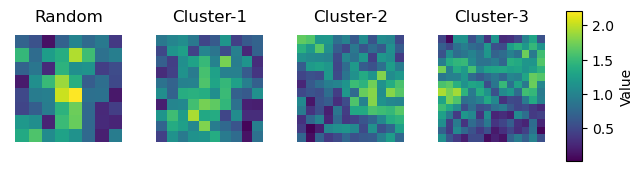

In [36]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Determine the global min and max values for "Value" across all 4 GeoDataFrames
vmin = min(
    gdf_cluster_str_1["Value"].min(),
    gdf_cluster_str_2["Value"].min(),
    gdf_cluster_str_3["Value"].min(),
    gdf_cluster_str_4["Value"].min()
)
vmax = max(
    gdf_cluster_str_1["Value"].max(),
    gdf_cluster_str_2["Value"].max(),
    gdf_cluster_str_3["Value"].max(),
    gdf_cluster_str_4["Value"].max()
)

# Create a normalization object and define the colormap
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = "viridis"

# Create the figure with four subplots
fig, axs = plt.subplots(1, 4, figsize=(8, 5))

# Plot each GeoDataFrame using the same normalization and colormap
gdf_cluster_str_1.plot(column='Value', cmap=cmap, legend=False, ax=axs[0], norm=norm)
gdf_cluster_str_2.plot(column='Value', cmap=cmap, legend=False, ax=axs[1], norm=norm)
gdf_cluster_str_3.plot(column='Value', cmap=cmap, legend=False, ax=axs[2], norm=norm)
gdf_cluster_str_4.plot(column='Value', cmap=cmap, legend=False, ax=axs[3], norm=norm)

# Add titles to each subplot
axs[0].set_title('Random')
axs[1].set_title('Cluster-1')
axs[2].set_title('Cluster-2')
axs[3].set_title('Cluster-3')

# Remove axes for a cleaner look
for ax in axs:
    ax.set_axis_off()

# Create a ScalarMappable for the colorbar
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Dummy array needed for the colorbar

# Adjust spacing so there's room on the right for the colorbar
fig.subplots_adjust(right=0.8)

# Add a new axis for the colorbar at [left, bottom, width, height]
# Tweak these values to get the best position and size
cbar_ax = fig.add_axes([0.82, 0.35, 0.02, 0.3]) 
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Value")

plt.savefig('experiment_4_cluster_geo_2.png', dpi=300, bbox_inches='tight')
plt.show()

In [37]:
# get the max value of all of four grids
max_value = max(gdf_cluster_str_1['Value'].max(), gdf_cluster_str_2['Value'].max(), gdf_cluster_str_3['Value'].max(), gdf_cluster_str_4['Value'].max())
min_value = min(gdf_cluster_str_1['Value'].min(), gdf_cluster_str_2['Value'].min(), gdf_cluster_str_3['Value'].min(), gdf_cluster_str_4['Value'].min())

# min max normalization
gdf_cluster_str_1['Value'] = (gdf_cluster_str_1['Value'] - min_value) / (max_value - min_value)
gdf_cluster_str_2['Value'] = (gdf_cluster_str_2['Value'] - min_value) / (max_value - min_value)
gdf_cluster_str_3['Value'] = (gdf_cluster_str_3['Value'] - min_value) / (max_value - min_value)
gdf_cluster_str_4['Value'] = (gdf_cluster_str_4['Value'] - min_value) / (max_value - min_value)

Calculating for Cluster - 1
Calculating for Cluster - 2
Calculating for Cluster - 3
Calculating for Cluster - 4


/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_34006/692558944.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df,new_row],ignore_index=True)


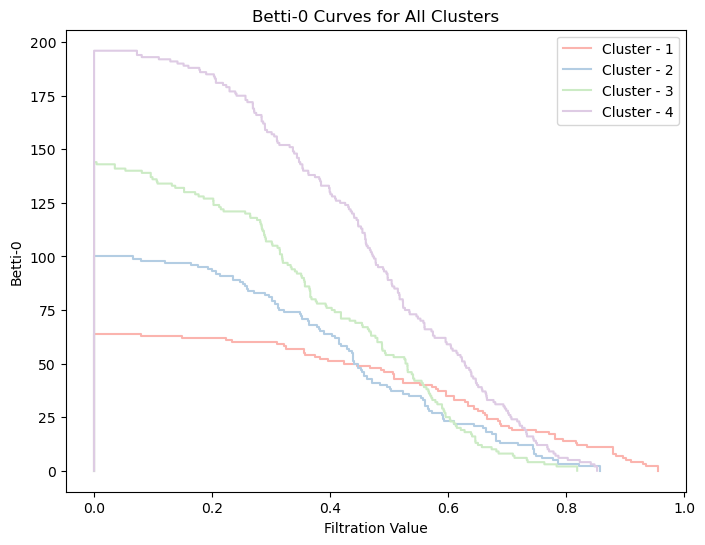

In [38]:
results_df = pd.DataFrame(columns=['GDF','Filter Method','TL','AL','TML','AML','Average'])

# create a dictionary to gdf and name
gdf_dict = {'Cluster - 1':gdf_cluster_str_1,
            'Cluster - 2':gdf_cluster_str_2,
            'Cluster - 3':gdf_cluster_str_3,
            'Cluster - 4':gdf_cluster_str_4}

# Create one figure for all clusters
plt.figure(figsize=(8, 6))
for name,gdf in gdf_dict.items():
    gdf_temp = gdf.copy()

    average_value = gdf_temp['Value'].mean()
    
    print(f"Calculating for {name}")
    # Initialize the AdjacencySimplex class
    adj_simplex = AdjacencySimplex(gdf_temp, 'Value', threshold = None, filter_method = 'down')

    # Filter the GeoDataFrame
    filtered_df,gdf_id = adj_simplex.filter_sort_gdf()

    # Calculate the adjacent countries
    adj_simplex.calculate_adjacent_countries()

    # Form the simplicial complex
    simplex = adj_simplex.form_simplicial_complex()

    # Compute the persistence
    _,TL, AL, TML, AML,intervals_dim0 = compute_persistence(simplices=simplex,filtered_df=filtered_df,variable_name='Value')

    # Add the results to the results_df
    new_row = pd.DataFrame({'GDF': name,
                                'Filter Method': ['down'],
                                'TL': [TL],
                                'AL': [AL],
                                'TML': [TML],
                                'AML': [AML],
                                'Average': average_value},
                                )
    results_df = pd.concat([results_df,new_row],ignore_index=True)

    # Get Betti-0 step data for this cluster
    x_vals, y_vals = get_betti0_step_data(intervals_dim0)
    
    # Plot on the same figure with a label
    plt.step(x_vals, y_vals, where='post', label=name)


# Add a legend and labels
plt.xlabel("Filtration Value")
plt.ylabel("Betti-0")
plt.title("Betti-0 Curves for All Clusters")
plt.legend()
plt.show()

Calculating for Cluster - 1
Calculating for Cluster - 2
Calculating for Cluster - 3
Calculating for Cluster - 4


/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_34006/1447760918.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


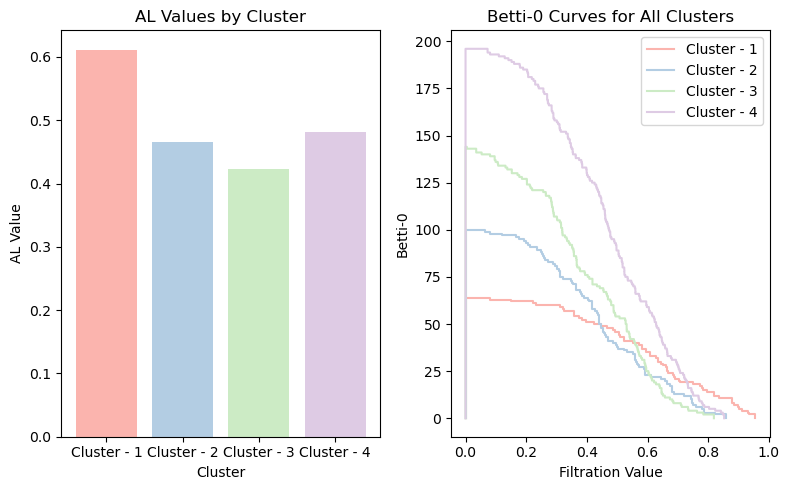

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
from cycler import cycler


# Suppose results_df is initially empty with the desired columns
results_df = pd.DataFrame(columns=['GDF','Filter Method','TL','AL','TML','AML','Average'])

# Desired cluster order
desired_order = ["Cluster - 1", "Cluster - 2", "Cluster - 3", "Cluster - 4"]

# Mapping of cluster names to their corresponding GeoDataFrames
gdf_dict = {
    'Cluster - 1': gdf_cluster_str_1,
    'Cluster - 2': gdf_cluster_str_2,
    'Cluster - 3': gdf_cluster_str_3,
    'Cluster - 4': gdf_cluster_str_4
}

# Example: Set the color cycle to use colors from the 'Set1' colormap
plt.rcParams['axes.prop_cycle'] = cycler(color=plt.get_cmap('Pastel1').colors)

# Create a color mapping for each cluster using the default matplotlib color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_dict = {cluster: colors[i % len(colors)] for i, cluster in enumerate(desired_order)}

# Create a figure with two subplots arranged horizontally:
# Left: Vertical bar plot for AL values
# Right: Betti-0 curves
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 5))

# Loop through each cluster to compute persistence and Betti-0 curve data
for name, gdf in gdf_dict.items():
    gdf_temp = gdf.copy()
    average_value = gdf_temp['Value'].mean()
    
    print(f"Calculating for {name}")
    # Initialize and run the persistence pipeline
    adj_simplex = AdjacencySimplex(gdf_temp, 'Value', threshold=None, filter_method='down')
    filtered_df, gdf_id = adj_simplex.filter_sort_gdf()
    adj_simplex.calculate_adjacent_countries()
    simplex = adj_simplex.form_simplicial_complex()
    _, TL, AL, TML, AML, intervals_dim0 = compute_persistence(
        simplices=simplex,
        filtered_df=filtered_df,
        variable_name='Value'
    )
    
    # Append computed metrics to results_df
    new_row = pd.DataFrame({
        'GDF': [name],
        'Filter Method': ['down'],
        'TL': [TL],
        'AL': [AL],
        'TML': [TML],
        'AML': [AML],
        'Average': [average_value]
    })
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    # Get Betti-0 step data and plot on the right subplot using the cluster's assigned color
    x_vals, y_vals = get_betti0_step_data(intervals_dim0)
    ax2.step(x_vals, y_vals, where='post', label=name, color=color_dict[name])

# Reindex results_df so that the rows follow the desired cluster order
results_df_ordered = results_df.set_index('GDF').reindex(desired_order)

# Plot a vertical bar plot for AL values on the left subplot.
ax1.bar(results_df_ordered.index, results_df_ordered['AL'],
         color=[color_dict[cluster] for cluster in desired_order])
ax1.set_title("AL Values by Cluster")
ax1.set_xlabel("Cluster")
ax1.set_ylabel("AL Value")

# Format the Betti-0 subplot
ax2.set_title("Betti-0 Curves for All Clusters")
ax2.set_xlabel("Filtration Value")
ax2.set_ylabel("Betti-0")
ax2.legend()

plt.tight_layout()
# plt.show()
plt.savefig('experiment_4_al_and_betti.png', dpi=300, bbox_inches='tight')


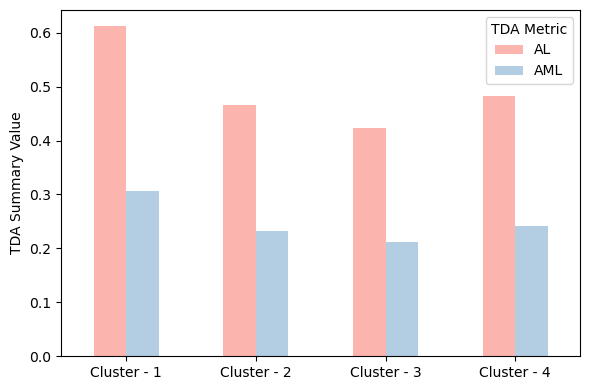

In [40]:

# Assume results_df has columns: ['GDF', 'Filter Method', 'AL', 'AML']
# Example desired order:
desired_order = ["Cluster - 1", "Cluster - 2", "Cluster - 3", "Cluster - 4"]

# 1. Pivot AL and AML separately
pivot_al = results_df.pivot(index='GDF', columns='Filter Method', values='AL')
pivot_aml = results_df.pivot(index='GDF', columns='Filter Method', values='AML')

# 2. Collapse across all Filter Methods by taking an average
pivot_al['AL'] = pivot_al.mean(axis=1)   # average AL across filter methods
pivot_aml['AML'] = pivot_aml.mean(axis=1)  # average AML across filter methods

# 3. Keep only the single "AL" or "AML" column
pivot_al = pivot_al[['AL']]   # discard the individual filter-method columns
pivot_aml = pivot_aml[['AML']]

# 4. Combine AL and AML side by side
combined = pd.concat([pivot_al, pivot_aml], axis=1)

# 5. Reorder the rows by your desired GDF order
combined = combined.reindex(desired_order)

# 6. Plot a grouped bar chart
fig, ax = plt.subplots(figsize=(6, 4))
combined.plot(kind='bar', ax=ax)

# ax.set_title("AL and AML (Averaged Across All Filter Methods), by GDF")
# ax.set_xlabel("GDF")
#remove the x label
plt.xticks(rotation=0)
ax.set_xlabel(None)
ax.set_ylabel("TDA Summary Value")

plt.legend(title="TDA Metric")  # No filter methods anymore, only metrics
plt.tight_layout()

plt.show()
# save plot with DPI 300
# plt.savefig('experiment_2_cluster_bar_tda.png', dpi=300, bbox_inches='tight')


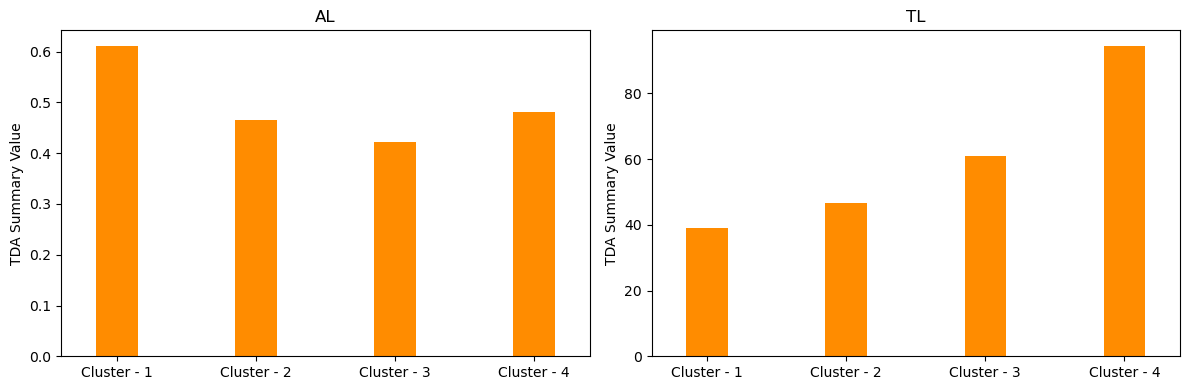

In [41]:
desired_order = ["Cluster - 1", "Cluster - 2", "Cluster - 3", "Cluster - 4"]

# Reindex the DataFrame to enforce the desired order
combined = results_df.set_index('GDF').reindex(desired_order)

# Create a figure with two subplots arranged horizontally
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

# Plot AL on the left subplot
combined['AL'].plot(kind='bar', ax=ax1, color='darkorange',width=0.3, legend=False)
ax1.set_title("AL")
ax1.set_xlabel(None)
ax1.set_ylabel("TDA Summary Value")
ax1.set_xticklabels(desired_order, rotation=0)

# Plot AML on the right subplot
combined['TL'].plot(kind='bar', ax=ax2, color='darkorange',width=0.3, legend=False)
ax2.set_title("TL")
ax2.set_xlabel(None)
ax2.set_ylabel("TDA Summary Value")
ax2.set_xticklabels(desired_order, rotation=0)

plt.tight_layout()
# plt.savefig('experiment_2_cluster_bar_tda.png', dpi=300, bbox_inches='tight')
plt.show()